##1. Customer Segmentation

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 6, 30)
PRODUCT_IDS = range(1, 101)
CUSTOMER_IDS = range(1, 101)

# Generate random customer purchase data
np.random.seed(42)
random.seed(42)

# Create a list to store purchase records
purchase_records = []

for customer_id in CUSTOMER_IDS:
    num_purchases = np.random.randint(1, 6)
    for _ in range(num_purchases):
        purchase_date = START_DATE + timedelta(days=random.randint(0, (END_DATE - START_DATE).days))
        product_id = random.choice(PRODUCT_IDS)
        amount_spent = round(random.uniform(10, 300), 2)
        purchase_records.append((customer_id, purchase_date, product_id, amount_spent))

# Create DataFrame
customer_purchases = pd.DataFrame(purchase_records, columns=['customer_id', 'purchase_date', 'product_id', 'amount_spent'])

# Save to CSV
customer_purchases.to_csv('customer_purchases.csv', index=False)

# Display the DataFrame
customer_purchases.head(21)

,customer_id,purchase_date,product_id,amount_spent
0,1,2024-06-12,15,17.25
1,1,2024-03-11,32,74.73
2,1,2024-01-27,87,224.79
3,1,2024-05-19,12,181.24
4,2,2024-01-09,4,37.17
5,2,2024-02-29,65,184.59
6,2,2024-05-23,26,217.65
7,2,2024-06-28,70,131.66
8,2,2024-04-24,76,90.68
9,3,2024-01-02,98,243.69


In [4]:
# Load the data
customer_purchases = pd.read_csv('customer_purchases.csv')

# Aggregate spending by customer
customer_spending = customer_purchases.groupby('customer_id')['amount_spent'].sum().reset_index()

# Round the total amount spent to 2 decimal places
customer_spending['amount_spent'] = customer_spending['amount_spent'].round(2)

# Classify customers based on provided thresholds
def classify_customer(amount):
    if amount < 100:
        return 'Low Spender'
    elif 100 <= amount < 500:
        return 'Medium Spender'
    else:
        return 'High Spender'

# Classify customers
customer_spending['segment'] = customer_spending['amount_spent'].apply(classify_customer)

# Save the results to a new CSV file
customer_spending.to_csv('customer_segments.csv', index=False)

##2. Data Collection and integration

###High-level ETL process diagram: [click here](https://drive.google.com/file/d/1NHIp9YQ40EJwV345ckU1duaZeFLEbGIB/view?usp=drive_link)

In [5]:
import os

NUM_STORES = 3
NUM_PRODUCTS = 6
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 1, 1)

# Generate a list of dates
dates = pd.date_range(START_DATE, END_DATE).tolist()

# Ensure the directory exists
output_directory = 'sales_inventory'
os.makedirs(output_directory, exist_ok=True)

# Generate data for each store and save in one CSV file per store
for store_id in range(1, NUM_STORES + 1):
    data = []
    for date in dates:
        for product_id in range(1, 101 + NUM_PRODUCTS):
            quantity_sold = np.random.randint(1, 11)
            quantity_in_stock = np.random.randint(10, 51)
            revenue = round(quantity_sold * np.random.uniform(10, 30), 2)
            data.append([store_id, date.strftime('%Y-%m-%d'), product_id, quantity_sold, quantity_in_stock, revenue])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['store_id', 'date', 'product_id', 'quantity_sold', 'quantity_in_stock', 'revenue'])

    # Save to CSV file
    filename = f'store_{store_id}_daily.csv'
    df.to_csv(os.path.join(output_directory, filename), index=False)

###1. Extract

In [6]:
# Directory containing CSV files
csv_directory = 'sales_inventory'

# List all CSV files in the directory
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

# Extract: Read all CSV files into a single DataFrame
def extract_data(directory):
    data_frames = []
    for file in csv_files:
        df = pd.read_csv(os.path.join(directory, file))
        data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

raw_data = extract_data(csv_directory)

###2. Transform

In [7]:
# Transform: Clean the data
def transform_data(df):
    # Handle missing values
    df.fillna(0, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Ensure consistent data formats (only date part)
    df['date'] = pd.to_datetime(df['date']).dt.date
    return df

cleaned_data = transform_data(raw_data)

###3. Load

In [8]:
!pip install pandas sqlalchemy

In [9]:
from sqlalchemy import create_engine, text

# Load: Load the cleaned data into SQLite database
def load_data(df, db_name='centralized_database.db'):
    # Create a connection to the SQLite database
    engine = create_engine(f'sqlite:///{db_name}')

    # Load the cleaned data into the database
    df.to_sql('daily_sales_inventory', con=engine, if_exists='replace', index=False)

    # Create indexes for efficient querying
    with engine.connect() as connection:
        connection.execute(text("CREATE INDEX idx_store_date ON daily_sales_inventory (store_id, date)"))
        connection.execute(text("CREATE INDEX idx_product ON daily_sales_inventory (product_id)"))

    return engine

engine = load_data(cleaned_data)

# Verify the data in the database
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM daily_sales_inventory LIMIT 5"))
    for row in result:
        print(row)

(2, '2024-01-01', 1, 5, 13, 111.59)
(2, '2024-01-01', 2, 7, 11, 73.71)
(2, '2024-01-01', 3, 4, 33, 94.17)
(2, '2024-01-01', 4, 3, 42, 57.5)
(2, '2024-01-01', 5, 3, 46, 67.56)


##3.Data Storage and Management

###ER Diagram: [click here](https://drive.google.com/file/d/1LepGZc8baWPjALDEpN9A6If1ML36iEhN/view?usp=drive_link)

##SQL scripts

In [ ]:
CREATE TABLE category (
    category_id   NUMBER NOT NULL,
    category_name VARCHAR2(255)
);

ALTER TABLE category ADD CONSTRAINT category_pk PRIMARY KEY ( category_id );

CREATE TABLE daily_sales (
    sale_id       NUMBER NOT NULL,
    sale_date     DATE,
    quantity_sold NUMBER,
    revenue       NUMBER,
    store_id      NUMBER NOT NULL,
    product_id    NUMBER NOT NULL
);

ALTER TABLE daily_sales ADD CONSTRAINT daily_sales_pk PRIMARY KEY ( sale_id );

CREATE TABLE inventory (
    inventory_id      NUMBER NOT NULL,
    inventory_date    DATE,
    quantity_in_stock NUMBER,
    store_id          NUMBER NOT NULL,
    product_id        NUMBER NOT NULL
);

ALTER TABLE inventory ADD CONSTRAINT inventory_pk PRIMARY KEY ( inventory_id );

CREATE TABLE location (
    "location_id " NUMBER NOT NULL,
    street         VARCHAR2(255),
    city           VARCHAR2(255),
    state_id       NUMBER NOT NULL
);

ALTER TABLE location ADD CONSTRAINT location_pk PRIMARY KEY ( "location_id " );

CREATE TABLE product (
    product_id   NUMBER NOT NULL,
    product_name VARCHAR2(255),
    price        NUMBER,
    category_id  NUMBER NOT NULL
);

ALTER TABLE product ADD CONSTRAINT product_pk PRIMARY KEY ( product_id );

CREATE TABLE state (
    state_id   NUMBER NOT NULL,
    state_name VARCHAR2(255)
);

ALTER TABLE state ADD CONSTRAINT state_pk PRIMARY KEY ( state_id );

CREATE TABLE store (
    store_id    NUMBER NOT NULL,
    store_name  VARCHAR2(255),
    location_id NUMBER NOT NULL
);

ALTER TABLE store ADD CONSTRAINT store_pk PRIMARY KEY ( store_id );

ALTER TABLE daily_sales
    ADD CONSTRAINT daily_sales_product_fk FOREIGN KEY ( product_id )
        REFERENCES product ( product_id );

ALTER TABLE daily_sales
    ADD CONSTRAINT daily_sales_store_fk FOREIGN KEY ( store_id )
        REFERENCES store ( store_id );

ALTER TABLE inventory
    ADD CONSTRAINT inventory_product_fk FOREIGN KEY ( product_id )
        REFERENCES product ( product_id );

ALTER TABLE inventory
    ADD CONSTRAINT inventory_store_fk FOREIGN KEY ( store_id )
        REFERENCES store ( store_id );

ALTER TABLE location
    ADD CONSTRAINT location_state_fk FOREIGN KEY ( state_id )
        REFERENCES state ( state_id );

ALTER TABLE product
    ADD CONSTRAINT product_category_fk FOREIGN KEY ( category_id )
        REFERENCES category ( category_id );

ALTER TABLE store
    ADD CONSTRAINT store_location_fk FOREIGN KEY ( location_id )
        REFERENCES location ( "location_id " );


By guaranteeing that data is normalized to 3NF, minimizing redundancy, and preserving data integrity, this schema design support efficient data management and querying. Clear definition of the relationships between tables makes it easier to query and reporting data quickly for a variety of analyses.

##4. Data Analysis and ML

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

engine = create_engine('sqlite:///centralized_database.db')
df_sales = pd.read_sql('SELECT * FROM daily_sales_inventory', engine)

# Display the first few rows of the sales data
df_sales.head()

,store_id,date,product_id,quantity_sold,quantity_in_stock,revenue
0,2,2024-01-01,1,5,13,111.59
1,2,2024-01-01,2,7,11,73.71
2,2,2024-01-01,3,4,33,94.17
3,2,2024-01-01,4,3,42,57.50
4,2,2024-01-01,5,3,46,67.56


In [12]:
# Display the shape of Data
df_sales.shape

(318, 6)

In [13]:
na_count = df_sales.isna().sum()

na_count

store_id             0
date                 0
product_id           0
quantity_sold        0
quantity_in_stock    0
revenue              0
dtype: int64

In [14]:
# Basic statistics
df_sales.describe()

,store_id,product_id,quantity_sold,quantity_in_stock,revenue
count,318.000000,318.000000,318.000000,318.000000,318.000000
mean,2.000000,53.500000,5.279874,29.940252,104.993931
std,0.817783,30.646427,2.883703,11.814532,66.869709
min,1.000000,1.000000,1.000000,10.000000,10.220000
25%,1.000000,27.000000,3.000000,20.000000,50.412500
50%,2.000000,53.500000,5.000000,30.000000,96.500000
75%,3.000000,80.000000,8.000000,40.000000,148.945000
max,3.000000,106.000000,10.000000,50.000000,299.250000


##EDA

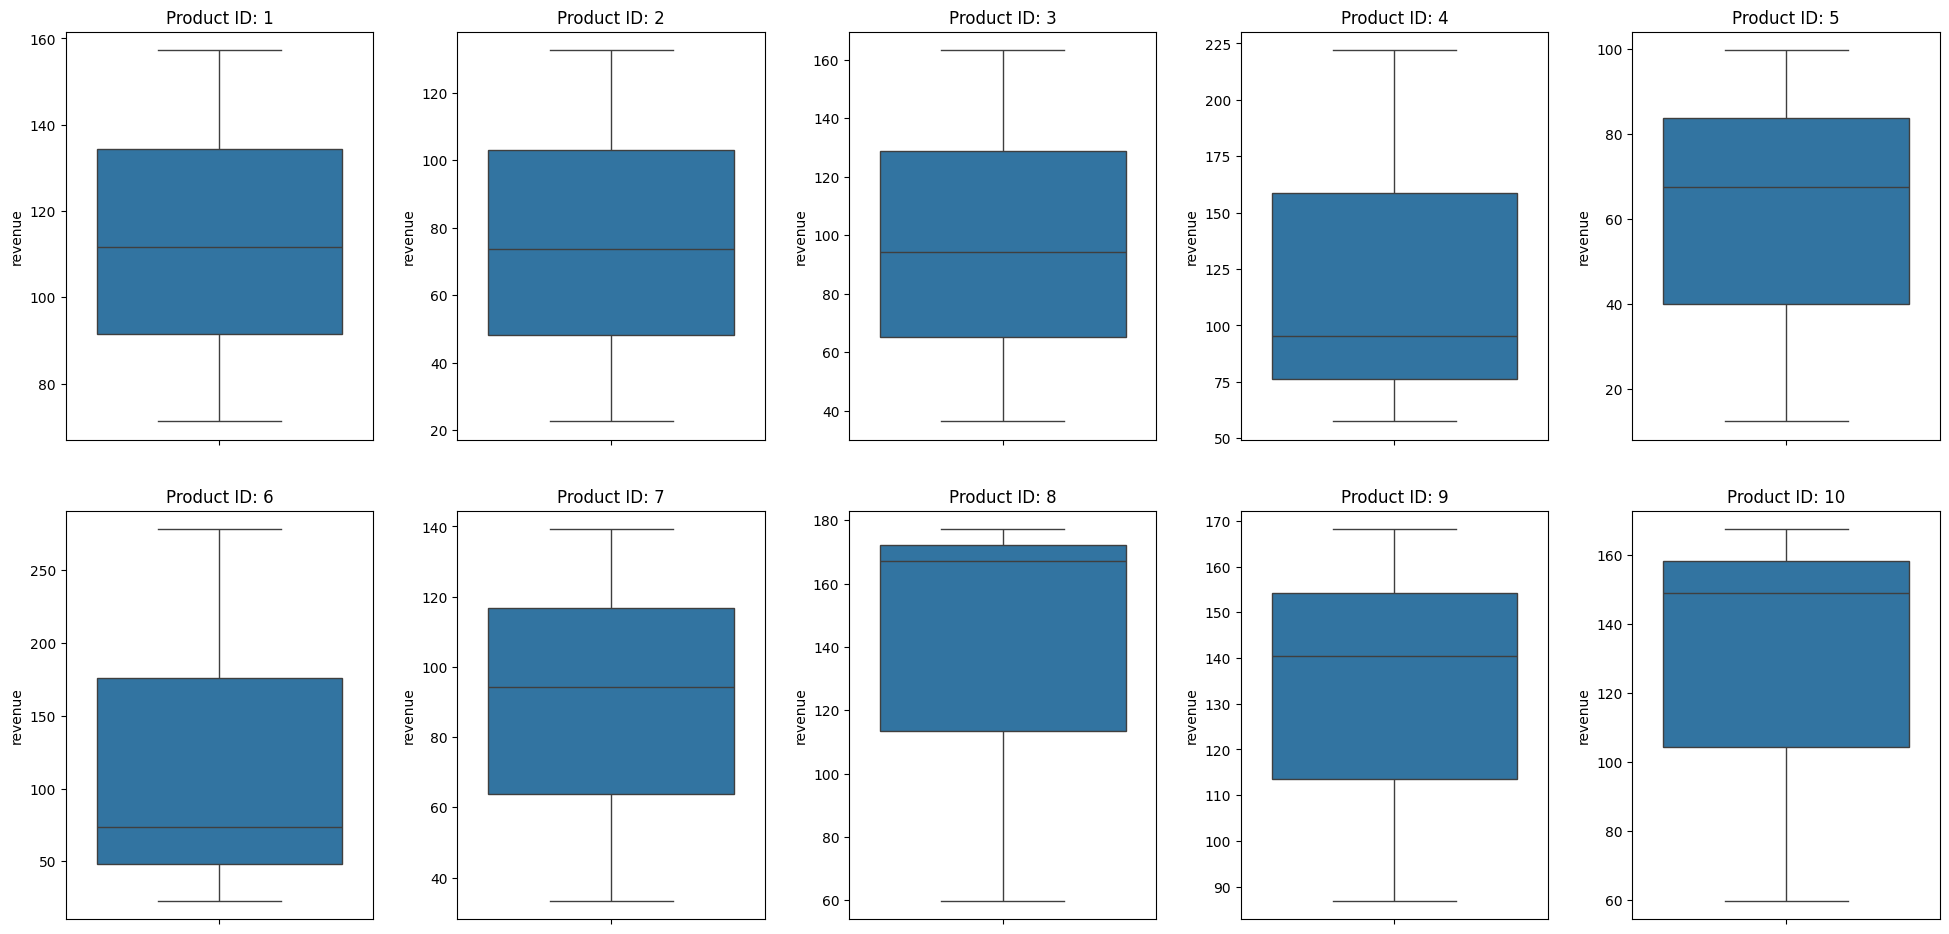

In [15]:
# Filter for the first 10 products
top_products = df_sales['product_id'].unique()[:10]

# Set up the figure for subplots
num_products = len(top_products)
num_cols = 5
num_rows = (num_products // num_cols) + (num_products % num_cols > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))
fig.tight_layout(pad=3.0)

# Plot each product's revenue as a box plot
i = 0
j = 0
for product_id in top_products:
    product_data = df_sales[df_sales['product_id'] == product_id]['revenue']
    sns.boxplot(ax=axes[i, j], y=product_data)
    axes[i, j].set_title(f'Product ID: {product_id}')
    j += 1
    if j == num_cols:
        j = 0
        i += 1

plt.show()

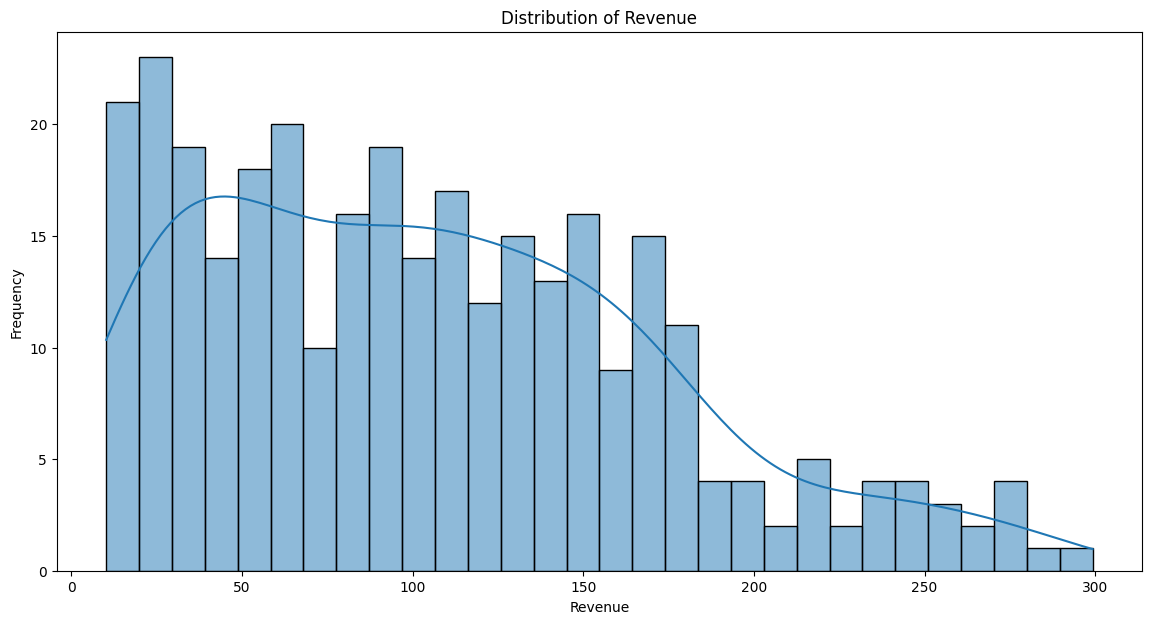

'Right-skewed, with few instances of very high revenue.'

In [33]:
# Distribution of revenue
plt.figure(figsize=(14, 7))
sns.histplot(df_sales['revenue'], bins=30, kde=True)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()
"""Right-skewed, with few instances of very high revenue."""

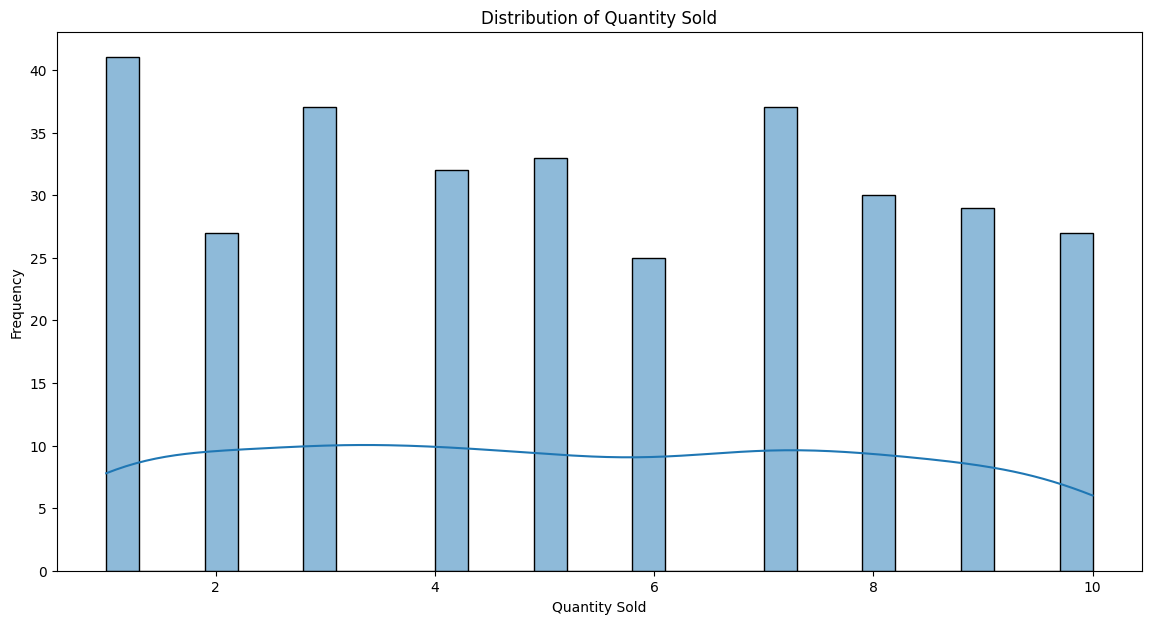

'Uniform distribution, indicating balanced demand across products.'

In [34]:
# Distribution of quantity sold
plt.figure(figsize=(14, 7))
sns.histplot(df_sales['quantity_sold'], bins=30, kde=True)
plt.title('Distribution of Quantity Sold')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()
"""Uniform distribution, indicating balanced demand across products."""

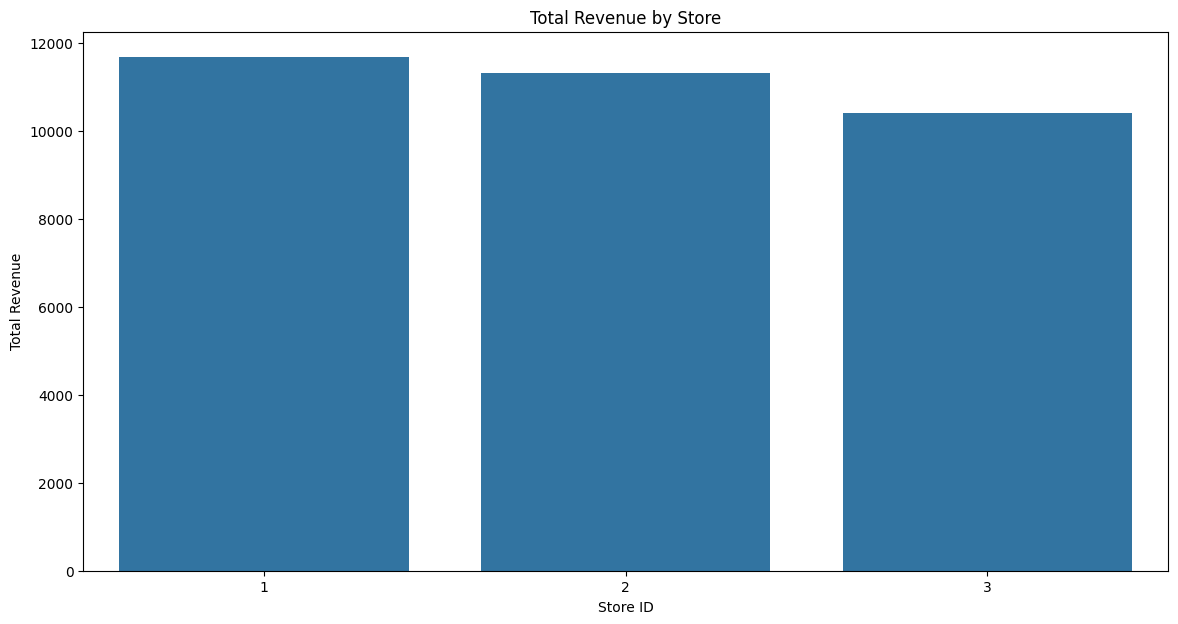

'Similar performance across stores, suggesting consistent strategies.'

In [35]:
# Total revenue by store
store_revenue = df_sales.groupby('store_id')['revenue'].sum().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(data=store_revenue, x='store_id', y='revenue')
plt.title('Total Revenue by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Revenue')
plt.show()
"""Similar performance across stores, suggesting consistent strategies."""

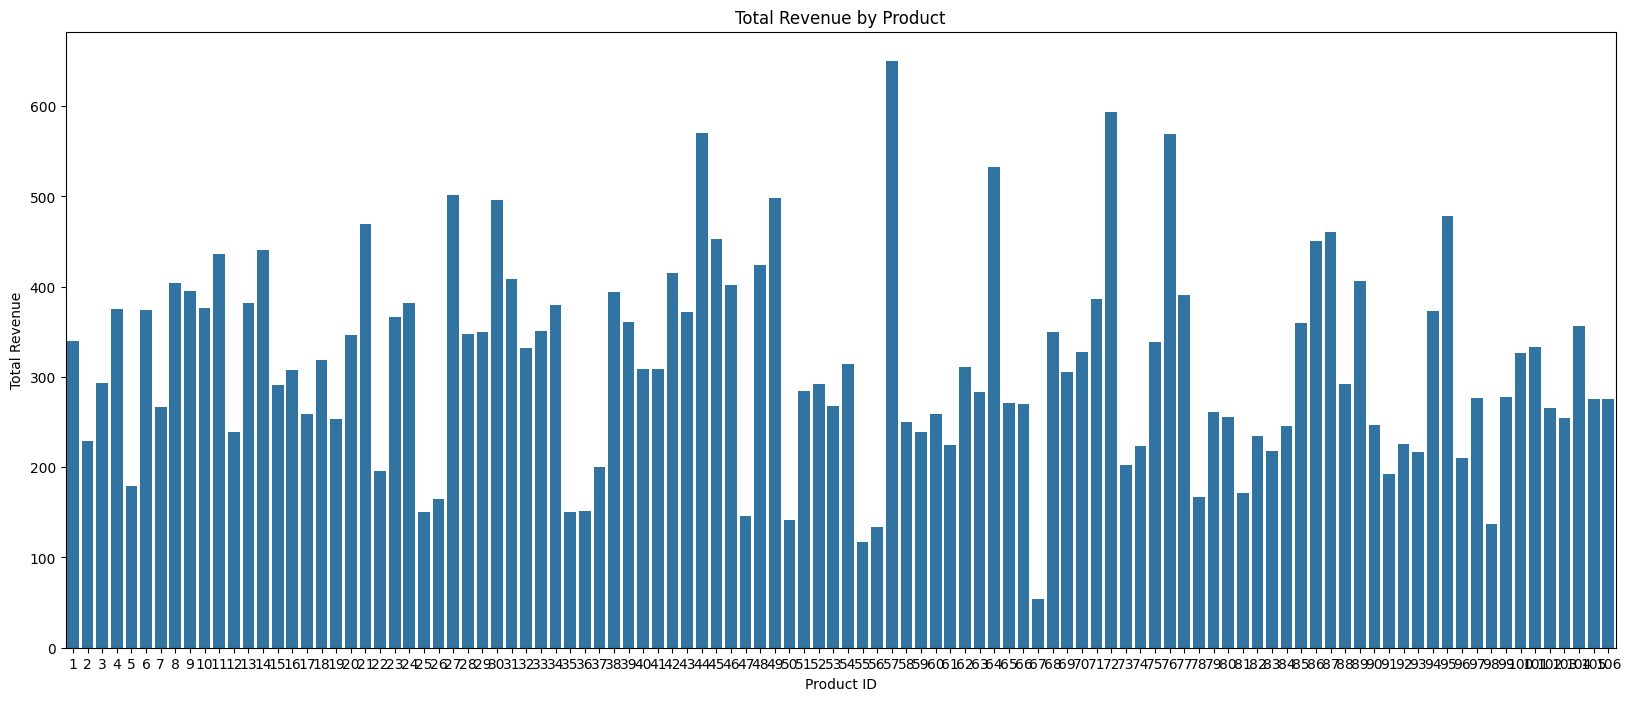

'Significant variability, highlighting top-performing products.'

In [36]:
# Total revenue by product
product_revenue = df_sales.groupby('product_id')['revenue'].sum().reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(data=product_revenue, x='product_id', y='revenue')
plt.title('Total Revenue by Product')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.show()
"""Significant variability, highlighting top-performing products."""

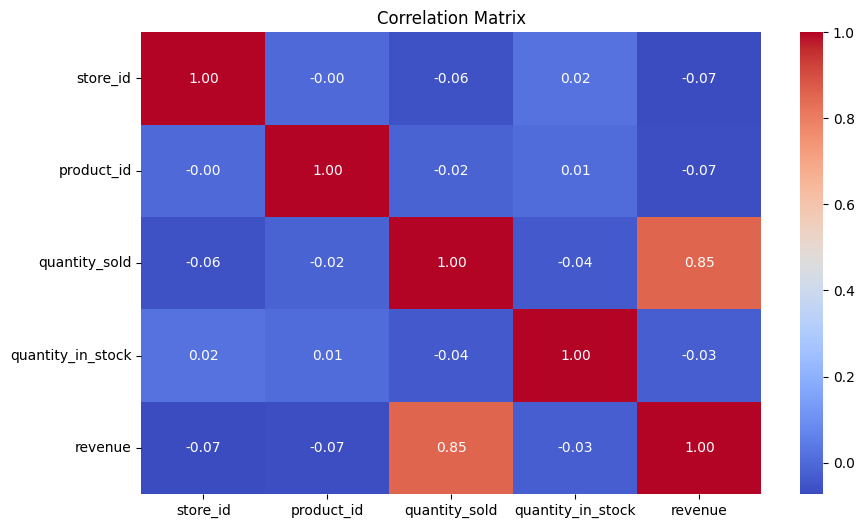

'Strong positive correlation between quantity_sold and revenue.'

In [37]:
# Correlation heatmap
df = df_sales.drop(['date'], axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
"""Strong positive correlation between quantity_sold and revenue."""

##Modeling

In [58]:
from sklearn.model_selection import train_test_split

# Convert date to datetime and extract relevant features
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales['day_of_week'] = df_sales['date'].dt.dayofweek
df_sales['month'] = df_sales['date'].dt.month

# Define features and target variable
features = ['store_id', 'product_id', 'day_of_week', 'month', 'revenue']
target = 'quantity_sold'

X = df_sales[features]
y = df_sales[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Custom feature engineering function
def add_custom_features(X):
    X_new = X.copy()
    X_new['RevenuePerDayOfWeek'] = X_new['revenue'] / (X_new['day_of_week'] + 1)
    X_new['RevenuePerMonth'] = X_new['revenue'] / X_new['month']
    return X_new

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['revenue']),
        ('cat', categorical_transformer, ['store_id', 'product_id', 'day_of_week', 'month']),
        ('custom', FunctionTransformer(add_custom_features), features)
    ], remainder='passthrough')

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# Define the RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor()
}

# Define the hyperparameter grids for each model
param_grids = {
    'LinearRegression': {},
    'RandomForestRegressor': {
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [None, 10, 30],
        'model__min_samples_split': [2, 5, 10],
    },
    'KNeighborsRegressor': {
        'model__n_neighbors': [3, 5, 7, 10],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan']
    }
}

# 3-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Train and tune the models using GridSearchCV
best_models = []
model_names = []
Xs_test = []

for model_name, model in models.items():
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grids[model_name], cv=cv, scoring=rmse_scorer, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    model_names.append(model_name)
    Xs_test.append(X_test)

    print(f'Best parameters for {model_name}: {grid_search.best_params_}')
    print(f'Best RMSE for {model_name}: {np.sqrt(-grid_search.best_score_)}\n')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for LinearRegression: {}
Best RMSE for LinearRegression: 63115.346937777955

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for RandomForestRegressor: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 500}
Best RMSE for RandomForestRegressor: 1.1903860943991713

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for KNeighborsRegressor: {'model__metric': 'manhattan', 'model__n_neighbors': 10, 'model__weights': 'uniform'}
Best RMSE for KNeighborsRegressor: 1.1874464425229427



In [61]:
# Evaluate each model
for name, model in zip(model_names, best_models):
    predictions = model.predict(X_test)
    rmse_value = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{name} - RMSE: {rmse_value}")

# Selecting the best model based on RMSE
best_model_name = model_names[0]
best_model = best_models[0]
for name, model in zip(model_names, best_models):
    rmse_value = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    if rmse_value < np.sqrt(mean_squared_error(y_test, best_model.predict(X_test))):
        best_model_name = name
        best_model = model

print(f"Best model based on RMSE: {best_model_name}")

LinearRegression - RMSE: 1.8831243454400262
RandomForestRegressor - RMSE: 1.220182729304834
KNeighborsRegressor - RMSE: 1.3053376000100512
Best model based on RMSE: RandomForestRegressor


In [62]:
# Generate future dates for prediction
future_dates = pd.date_range(start='2024-07-01', end='2024-07-07')
future_data = []

for store_id in df_sales['store_id'].unique():
    for product_id in df_sales['product_id'].unique():
        for date in future_dates:
            day_of_week = date.dayofweek
            month = date.month
            revenue = np.random.uniform(10, 1000)  # Generate plausible future revenue
            future_data.append([store_id, product_id, day_of_week, month, revenue])

future_df = pd.DataFrame(future_data, columns=['store_id', 'product_id', 'day_of_week', 'month', 'revenue'])

# Predict future quantity sold
future_df['predicted_quantity_sold'] = best_model.predict(future_df)

# Aggregate predictions for inventory recommendations
inventory_recommendations = future_df.groupby(['store_id', 'product_id'])['predicted_quantity_sold'].sum().reset_index()
inventory_recommendations.columns = ['store_id', 'product_id', 'recommended_quantity_sold']

# Save inventory recommendations to a CSV file
inventory_recommendations.to_csv('inventory_recommendations.csv', index=False)

print(inventory_recommendations)

     store_id  product_id  recommended_quantity_sold
0           1           1                  43.821494
1           1           2                  45.573808
2           1           3                  51.679555
3           1           4                  52.213000
4           1           5                  43.394598
..        ...         ...                        ...
313         3         102                  41.753213
314         3         103                  44.269003
315         3         104                  49.356263
316         3         105                  34.631495
317         3         106                  53.996053

[318 rows x 3 columns]


#Insights and Recommendations

1. High Demand Products: Products with consistently high predicted sales should be prioritized for inventory replenishment to prevent stockouts.
 Recommendation: Increase stock levels for products with predicted high sales (e.g., products 1, 3, 4, and 106).

2. Low Demand Products: Products with lower predicted sales can have reduced inventory levels to avoid overstock.
 Recommendation: Adjust stock levels for products with low predicted sales (e.g., product 105).

3. Store-specific Trends: Some stores may have higher predicted sales for certain products.
 Recommendation: Tailor inventory levels based on store-specific demand patterns. For example, if store 3 shows high demand for product 106, ensure adequate stock is maintained at that store.

4. Promotional Strategies: Identify products with medium predicted sales for potential promotional activities to boost sales.
 Recommendation: Implement promotions for products with moderate demand to increase turnover and prevent overstock. For example, consider promotions for products with predicted sales around 40-50 units.
5. Inventory Optimization: Use predictive insights to optimize the supply chain and inventory management process.
 Recommendation: Continuously monitor and adjust inventory levels based on updated predictions and sales data. Implement an automated system to regularly update predictions and inventory recommendations.

##Additional Ideas to Apply ML or LLMs
1. Customer Segmentation: Use clustering algorithms to segment customers based on purchase behavior for targeted marketing and personalized campaigns.
2. Sentiment Analysis: Employ LLMs like BERT or GPT to analyze customer reviews, gaining insights into satisfaction and feedback for product improvement.
3. Demand Forecasting: Utilize time series models to predict future sales, optimizing inventory levels and reducing costs.
4. Dynamic Pricing: Implement reinforcement learning for adaptive pricing strategies to maximize revenue.
5. Churn Prediction: Use classification models to identify at-risk customers and implement retention strategies.
6. Automated Customer Support: Deploy chatbots powered by LLMs to handle customer inquiries efficiently, improving service responsiveness.